In [34]:
#Autoreload to be able to tweak source code in the fly without restarting kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import aligater as ag
import numpy as np
import math

In [36]:
fcsDF = ag.loadFCS("/media/ludvig/Project_Storage/GAIM/data/GAIM_fcs/01-03-2016/plate 1/B cells_A2_A02_030.fcs")

Loaded dataset with 279440 rows.
Marker labels: IgA CD27 CD34 CD19 IgD CD45 CD38 CD24 

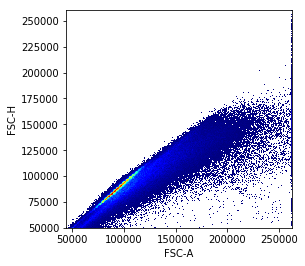

In [37]:
fig, ax = ag.plotHeatmap(fcsDF,"FSC-A", "FSC-H")

In [38]:
no_clutter=ag.gateThreshold(fcsDF,"FSC-A",thresh=260000,population="lower")

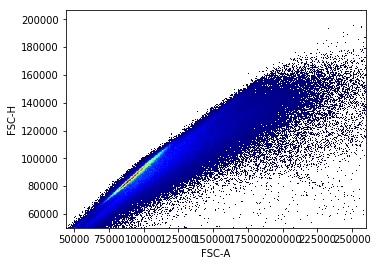

In [39]:
fig, ax = ag.plotHeatmap(fcsDF,"FSC-A", "FSC-H", vI=no_clutter)

In [40]:
barycenter, eigen1, eigen2 = ag.getPCs(fcsDF, "FSC-A", "FSC-H", no_clutter)

In [44]:
PC1, PC2 = ag.getPCSemiAxis(barycenter, eigen1, eigen2, 3, 3)

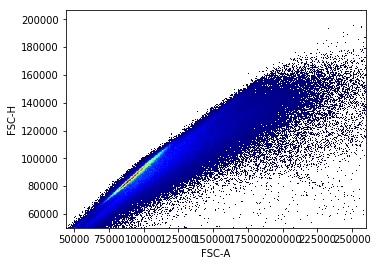

In [45]:
fig, ax = ag.plotHeatmap(fcsDF,"FSC-A", "FSC-H", vI=no_clutter)

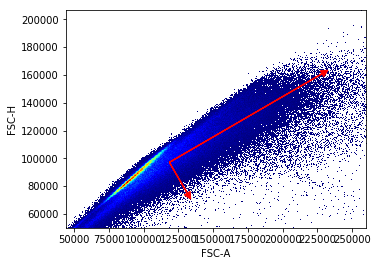

In [52]:
ax.arrow(barycenter[0], barycenter[1], PC1[0]-barycenter[0], PC1[1]-barycenter[1], head_width=5000, head_length=5000, fc='r', ec='r')
ax.arrow(barycenter[0], barycenter[1], PC2[0]-barycenter[0], PC2[1]-barycenter[1], head_width=5000, head_length=5000, fc='r', ec='r')
fig

In [47]:
axis1=np.sqrt(np.sum(np.square(np.subtract(PC1,barycenter))))
axis2=np.sqrt(np.sum(np.square(np.subtract(PC2,barycenter))))
angle=math.atan(np.subtract(PC1,barycenter)[1]/np.subtract(PC1,barycenter)[0])

In [48]:
singlets = ag.gateEllipsoid(fcsDF, "FSC-A", "FSC-H",xCenter=barycenter[0],yCenter=barycenter[1],majorRadii=axis1, minorRadii=axis2,theta=angle,vI=no_clutter)

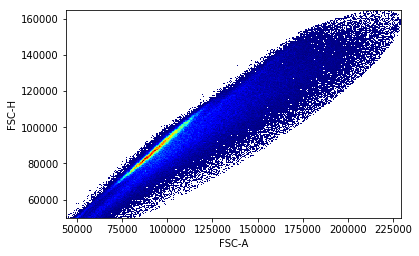

(<matplotlib.figure.Figure at 0x7f2687302048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f26872f48d0>)

In [49]:
ag.plotHeatmap(fcsDF, "FSC-A", "FSC-H", singlets)

Let's restart...

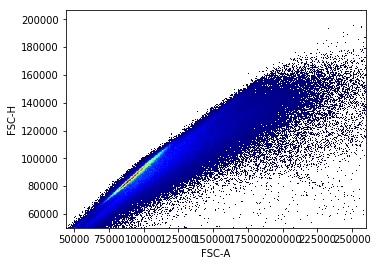

(<matplotlib.figure.Figure at 0x7f2686ad26d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2686acd4a8>)

In [54]:
ag.plotHeatmap(fcsDF, "FSC-A", "FSC-H", no_clutter)